<a href="https://www.kaggle.com/code/furkanuysl/identifying-ship-in-satellite-images-ann-cnn?scriptVersionId=92493563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<p>
<font size="9" face="Arial">
<h1 align="center"> Ship Satellite Image Classification </h1>
</font>
</p>


--------------

   
<p>
<font size="6" face="Arial">
<h1 align="left"> Content </h1>
</font>
</p>

    
<p>
<font size="4" face="1">
<ol type="A">
<li>Dataset Information</li>
                <ul>
                <li>Context</li>
                <li>Content</li>
                <li>Class Labels</li>
                </ul>
<li>Loading and Checking Dataset</li>
                <ul>
                <li>Loding and Reshaping</li>
                <li>Exploring the Images</li>
                </ul>
<li>Modelling</li>
                <ul>
                <li>Preparing of Test and Train Data</li>
                <li>Implementation of Artificial Neural Network (ANN)</li>
                <li>Implementation of Convolutional Neural Network (CNN)</li>  
                </ul>   
<ol>

</font>
</p>

<p>
<font size="4" face="Arial">In this notebook, I will create a model that predicts weather there is ship in the image or not.</font>
</p>

<p>
<font size="6" face="Arial">
<h2 align="left"> 1. Dataset Information </h2> 
</font>
</p>
<p>
<font size="5" face="Arial">
<h2 align="left"> Context </h2>
</font>
</p>

    
<p>
<font size="4" face="Arial">
Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day.

The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.
</font>
</p>
</br>
<p>
<font size="5" face="Arial">
<h2 align="left"> Content </h2>
</font>
<p>
<font size="4" face="Arial">
The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.
</font>
</p>
</br>   




<p>
<font size="4" face="Arial">    
The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.
<ol type="square">
<li>**label**: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.</li>
<li>**scene id**: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.</li>
<li>**longitude_latitude**: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.</li>    
</ol>    
The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image.
</font>
</p>
<p>
<font size="5" face="Arial">
<h2 align="left"> Class Labels </h2>
</font>
</p>

<p>
<font size="4" face="Arial">
The "ship" class includes 1000 images. Images in this class are near-centered on the body of a single ship. Ships of different sizes, orientations, and atmospheric collection conditions are included. Example images from this class are shown below.
</font>  
</p>

<figure class="half" style="center">
    <img style="width:700px" src="https://i.imgur.com/tLsSoTz.png">
</figure>
<p>
<font size="4" face="Arial">
The "no-ship" class includes 3000 images. A third of these are a random sampling of different landcover features - water, vegetion, bare earth, buildings, etc. - that do not include any portion of an ship. The next third are "partial ships" that contain only a portion of an ship, but not enough to meet the full definition of the "ship" class. The last third are images that have previously been mislabeled by machine learning models, typically caused by bright pixels or strong linear features. Example images from this class are shown below.
</font>
</p>
<figure class="half" style="center">
    <img style="width:700px" src="https://i.imgur.com/Q3daQMC.png">
</figure>


<p>
<font size="6" face="Arial">
<h2 align="left"> 2. Loading and Checking Dataset </h2> 
</font>
</p>
   



<p>
<font size="5" face="Arial">
<h2 align="left"> Loading and Reshaping </h2>
</font>
</p>

In [1]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [2]:
with open('../input/ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


<p>
<font size="4" face="Arial">
<li> We need just two columns in this project which are data and labels. </li>
</font>
</p>

In [4]:
shipsnet = shipsnet[["data", "labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [5]:
len(shipsnet["data"].iloc[0])

19200

 <p>
<font size="4" face="Arial">
<li> As you can see, the pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. </li>
</font>
</p>

In [6]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [7]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [8]:
x.shape

(4000, 19200)

<p>
<font size="4" face="Arial">
<li> The current data for each image is one row of flattened 19200 data points representing the RGB values of each pixel. So we need to reshape it. After reshaping, each item in new x variable will be 3 lists. Each of these lists will be RGB values for each pixel for the length and width of the image. </li>
</font>
</p>

In [9]:
x_reshaped = x.reshape([-1, 3, 80, 80])

x_reshaped.shape

(4000, 3, 80, 80)

<p>
<font size="4" face="Arial">
<li> We need to change the order of the dimensions to get the correct format to plot the images. The last value of the shape of x_reshaped will be 3, this number represent the channel. (RGB) </li>
</font>
</p>    

<img src="https://e2eml.school/images/image_processing/three_d_array.png" class="center" style="width:400px">



In [10]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [11]:
y.shape

(4000,)

<p>
<font size="4" face="Arial">
<li> y variable consist of label values, 1 or 0. We need to convert them binary class matrix. </li>
</font>
</p>

In [12]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [13]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

<p>
<font size="5" face="Arial">
<h2 align="left"> Exploring the Images </h2>
</font>
</p>

<p>
<font size="4" face="Arial">
<li> A quick look at images with and without ships. </li>
</font>
</p>

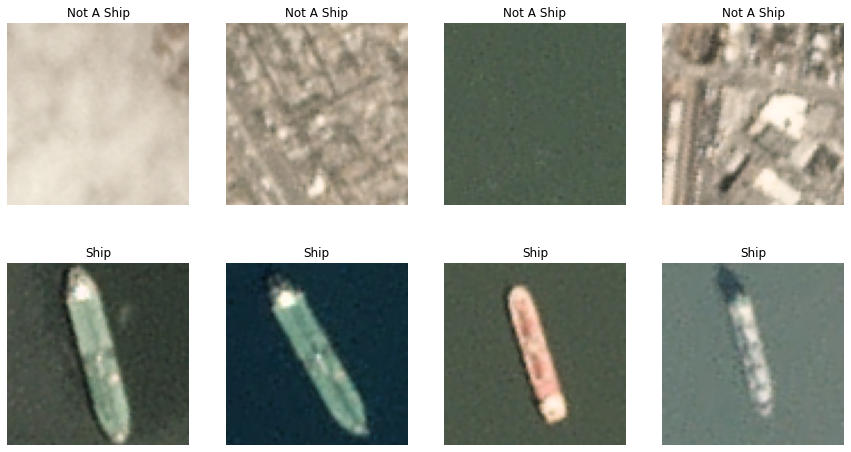

In [14]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

<p>
<font size="4" face="Arial">
<li> A quick look at pixel intensity of images. </li>
</font>
</p>

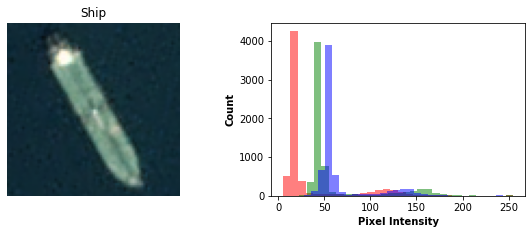

Minimum pixel value of this image: 5
Maximum pixel value of this image: 255


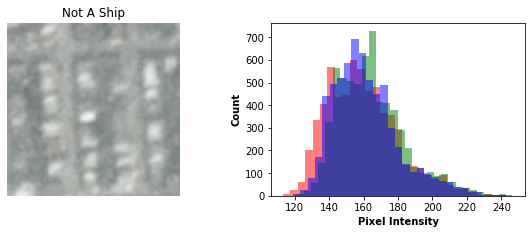

Minimum pixel value of this image: 113
Maximum pixel value of this image: 247


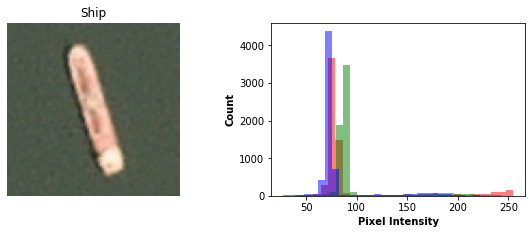

Minimum pixel value of this image: 27
Maximum pixel value of this image: 255


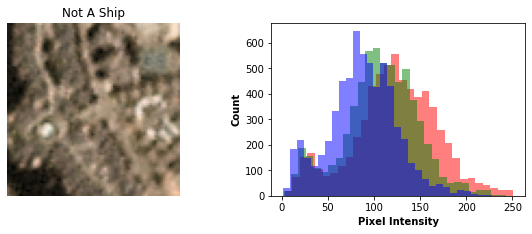

Minimum pixel value of this image: 1
Maximum pixel value of this image: 251


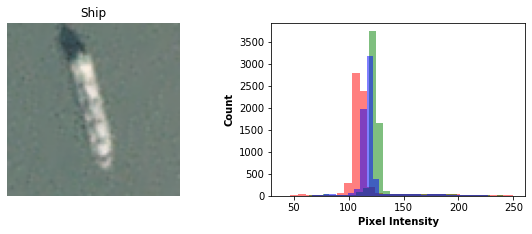

Minimum pixel value of this image: 40
Maximum pixel value of this image: 250


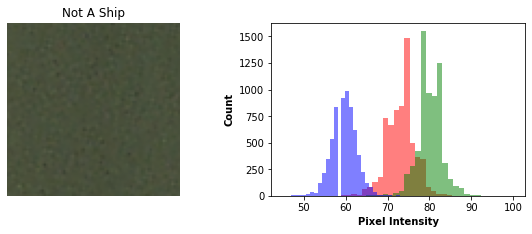

Minimum pixel value of this image: 45
Maximum pixel value of this image: 100


In [15]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))
#Implementation of the function

for i in range (20,23):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

<p>
<font size="4" face="Arial">
<li> Now let’s take a quick view of each channels in the two image. </li>
</font>
</p>

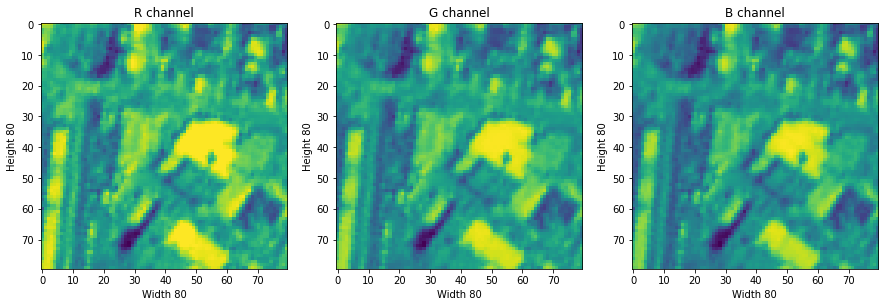

In [16]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

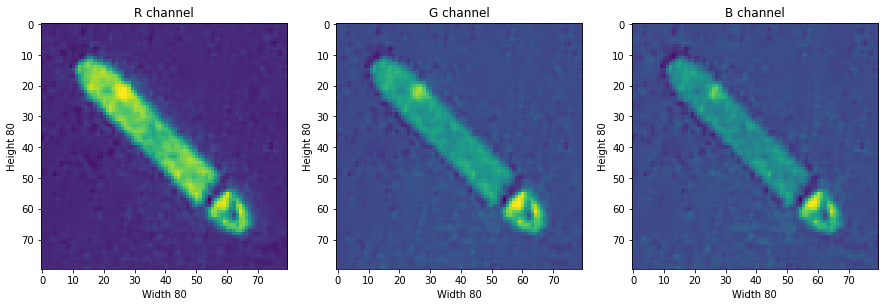

In [17]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

<p>
<font size="6" face="Arial">
<h2 align="left"> 3. Modelling </h2> 
</font>
</p>


<p>
<font size="5" face="Arial">
<h2 align="left"> Preparing of Train and Test Data </h2>
</font>
</p>

<p>
<font size="4" face="Arial">
<li> First step is normalizing x data. </li>
</font>
</p>

In [18]:
x_reshaped = x_reshaped / 255

In [19]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0.32156863, 0.36862745, 0.31372549])

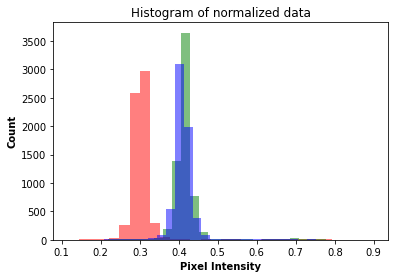

In [20]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

<p>
<font size="4" face="Arial">
<li> Data is ready for splitting as train and test. </li>
</font>
</p>

In [21]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)

x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)


In [22]:
x_train.shape

(2400, 80, 80, 3)

<p>
<font size="5" face="Arial">
<h2 align="left"> Implementation of Artificial Neural Network (ANN) </h2>
</font>
</p>

In [23]:
from keras import callbacks
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 2s 26ms/step - loss: 1.7987 - accuracy: 0.7010 - val_loss: 0.3326 - val_accuracy: 0.8687
Epoch 2/100
75/75 [==============================] - 1s 16ms/step - loss: 0.4621 - accuracy: 0.8353 - val_loss: 0.3232 - val_accuracy: 0.8637
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3370 - accuracy: 0.8655 - val_loss: 0.2643 - val_accuracy: 0.8975
Epoch 4/100
75/75 [==============================] - 1s 16ms/step - loss: 0.2856 - accuracy: 0.8821 - val_loss: 0.2859 - val_accuracy: 0.8775
Epoch 5/100
75/75 [==============================] - 1s 15ms/step - loss: 0.3122 - accuracy: 0.8721 - val_loss: 0.2458 - val_accuracy: 0.9062
Epoch 6/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3143 - accuracy: 0.8773 - val_loss: 0.4745 - val_accuracy: 0.8475
Epoch 7/100
75/75 [==============================] - 1s 15ms/step - loss: 0.3688 - accuracy: 0.8531 - val_loss: 0.2412 - val_accuracy: 0.9137
Epoch 

In [24]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.1928 - accuracy: 0.9362


[0.19276541471481323, 0.9362499713897705]

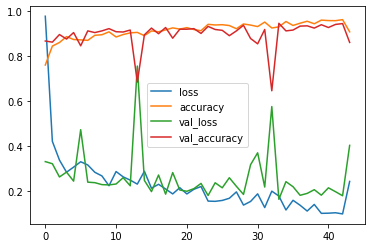

In [25]:
pd.DataFrame(history.history).plot();

<p>
<font size="4" face="Arial">
<li> Now I will add two more layer and change activation function as softmax . </li>
</font>
</p>

In [26]:
from keras import callbacks
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 2s 20ms/step - loss: 0.9878 - accuracy: 0.7200 - val_loss: 0.8661 - val_accuracy: 0.4050
Epoch 2/100
75/75 [==============================] - 1s 16ms/step - loss: 0.4484 - accuracy: 0.7983 - val_loss: 0.3144 - val_accuracy: 0.8637
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3364 - accuracy: 0.8527 - val_loss: 0.2868 - val_accuracy: 0.8925
Epoch 4/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3588 - accuracy: 0.8538 - val_loss: 0.2703 - val_accuracy: 0.8950
Epoch 5/100
75/75 [==============================] - 1s 16ms/step - loss: 0.2622 - accuracy: 0.8979 - val_loss: 0.2509 - val_accuracy: 0.8900
Epoch 6/100
75/75 [==============================] - 1s 17ms/step - loss: 0.2701 - accuracy: 0.8879 - val_loss: 0.2392 - val_accuracy: 0.9062
Epoch 7/100
75/75 [==============================] - 1s 16ms/step - loss: 0.2621 - accuracy: 0.8954 - val_loss: 0.3090 - val_accuracy: 0.8637
Epoch 

In [27]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 0s 5ms/step - loss: 0.2375 - accuracy: 0.8900


[0.23745357990264893, 0.8899999856948853]

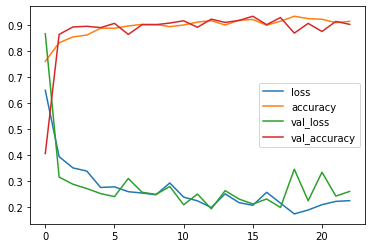

In [28]:
pd.DataFrame(history.history).plot();

<p>
<font size="4" face="Arial">
<li> Now we can predict our test data with ANN. I will check the first image of the test data. </li>
</font>
</p>

In [29]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

Not A Ship    0.16626
Ship          0.83374
dtype: float32

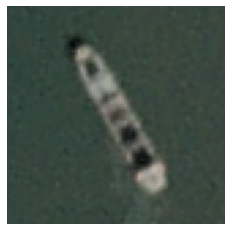

In [30]:
plt.imshow(x_test[0])
plt.axis("off")
plt.show()

<p>
<font size="4" face="Arial">
<li> Let's take a look at the images that are estimated to be ship, although not a ship. </li>
</font>
</p>

In [31]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head(3)

,Not A Ship,Ship
0,0.166260,0.833740
1,0.999375,0.000625
2,0.050441,0.949559


In [32]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(3)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0


In [33]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.166260,0.833740,1.0
1,0.999375,0.000625,0.0
2,0.050441,0.949559,1.0
3,0.057182,0.942818,0.0
4,0.995758,0.004241,0.0


In [34]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.166260,0.833740,1.0,-0.166260
1,0.999375,0.000625,0.0,0.000625
2,0.050441,0.949559,1.0,-0.050441
3,0.057182,0.942818,0.0,0.942818
4,0.995758,0.004241,0.0,0.004241
...,...,...,...,...
795,0.335853,0.664147,0.0,0.664147
796,0.203715,0.796285,1.0,-0.203715
797,0.907837,0.092163,0.0,0.092163
798,0.999684,0.000316,0.0,0.000316


<p>
<font size="4" face="Arial">
<li> If difference is high, that means the image predicted as Ship, altought not a ship. To see such predicted images, we need to sort the difference column from largest to smallest. </li>
</font>
</p>

In [35]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
528,0.007995,0.992005,0.0,0.992005
628,0.027841,0.972159,0.0,0.972159
662,0.035409,0.964591,0.0,0.964591
413,0.041244,0.958756,0.0,0.958756
3,0.057182,0.942818,0.0,0.942818
221,0.084774,0.915226,0.0,0.915226
657,0.097675,0.902325,0.0,0.902325
771,0.098345,0.901655,0.0,0.901655
783,0.104767,0.895233,0.0,0.895233
207,0.109321,0.890679,0.0,0.890679


<p>
<font size="4" face="Arial">
<li> Now, I want to show some of these images and their pixel intensity histograms. </li>
</font>
</p>

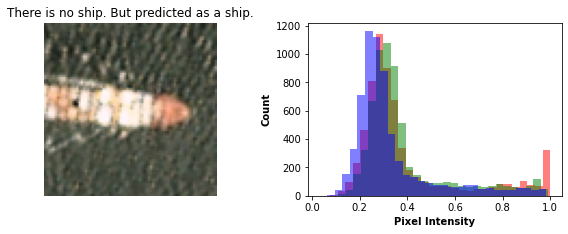

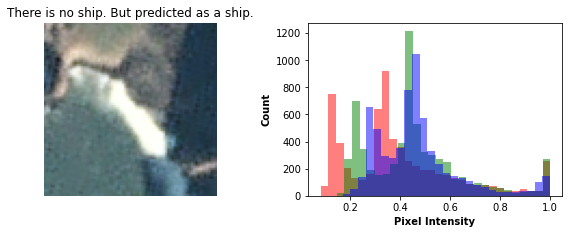

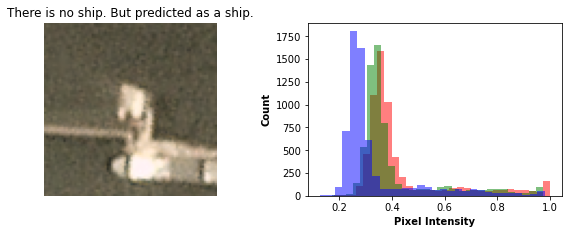

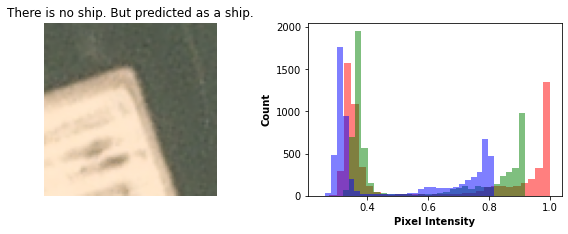

In [36]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


#Implementation of the function

for i in indexes:
    plotHistogram(i)

<p>
<font size="4" face="Arial">
<li> Now, let's take a look at the images that are estimated to not a ship, although there is a ship. </li>
</font>
</p>

In [37]:
predicted_data.sort_values('Difference', ascending=True).head(10)

,Not A Ship,Ship,There is a Ship,Difference
537,0.997948,0.002052,1.0,-0.997948
578,0.981572,0.018428,1.0,-0.981572
100,0.943437,0.056563,1.0,-0.943437
331,0.912735,0.087265,1.0,-0.912735
322,0.906604,0.093396,1.0,-0.906604
249,0.894004,0.105996,1.0,-0.894004
518,0.880044,0.119956,1.0,-0.880044
36,0.837857,0.162143,1.0,-0.837857
651,0.784058,0.215943,1.0,-0.784057
81,0.755869,0.244131,1.0,-0.755869


<p>
<font size="4" face="Arial">
<li> Now, I want to show some of these images and their pixel intensity histograms. </li>
</font>
</p>


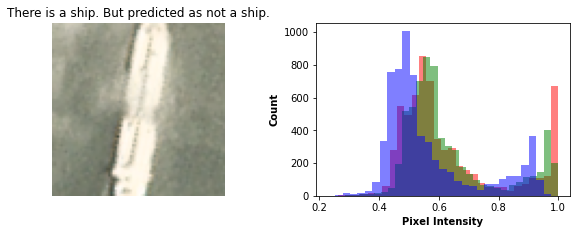

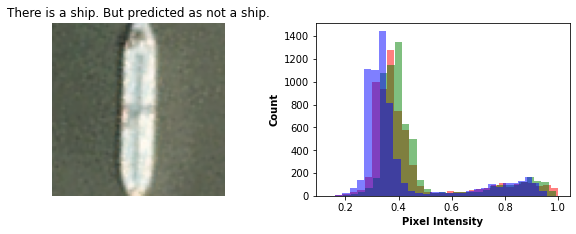

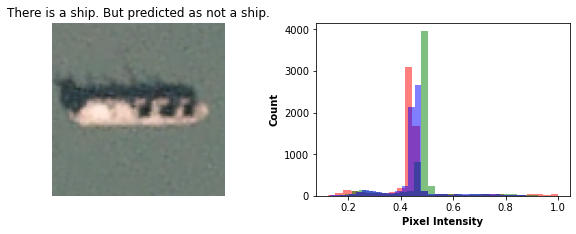

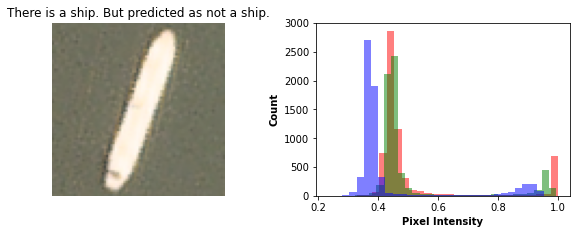

In [38]:
indexes = predicted_data.sort_values('Difference', ascending = True).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is a ship. But predicted as not a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


#Implementation of the function

for i in indexes:
    plotHistogram(i)

<p>
<font size="5" face="Arial">
<h2 align="left"> Implementation of Convolutional Neural Network (CNN) </h2>
</font>
</p>

In [39]:
from keras import callbacks
model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (80,80,3)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 14s 178ms/step - loss: 0.6235 - accuracy: 0.6976 - val_loss: 0.5694 - val_accuracy: 0.7513
Epoch 2/100
75/75 [==============================] - 13s 168ms/step - loss: 0.5698 - accuracy: 0.7413 - val_loss: 0.4282 - val_accuracy: 0.7513
Epoch 3/100
75/75 [==============================] - 13s 177ms/step - loss: 0.4415 - accuracy: 0.7631 - val_loss: 0.3308 - val_accuracy: 0.8875
Epoch 4/100
75/75 [==============================] - 13s 169ms/step - loss: 0.3620 - accuracy: 0.8371 - val_loss: 0.2695 - val_accuracy: 0.8875
Epoch 5/100
75/75 [==============================] - 13s 171ms/step - loss: 0.2692 - accuracy: 0.8880 - val_loss: 0.2763 - val_accuracy: 0.9125
Epoch 6/100
75/75 [==============================] - 13s 172ms/step - loss: 0.2097 - accuracy: 0.9151 - val_loss: 0.1942 - val_accuracy: 0.9388
Epoch 7/100
75/75 [==============================] - 12s 167ms/step - loss: 0.1709 - accuracy: 0.9305 - val_loss: 0.1844 - val_accuracy:

In [40]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 1s 48ms/step - loss: 0.0541 - accuracy: 0.9900


[0.054107122123241425, 0.9900000095367432]

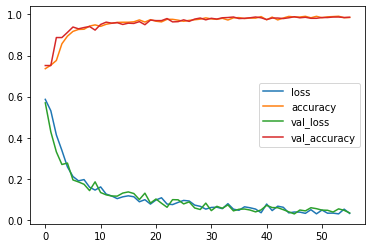

In [41]:
pd.DataFrame(history.history).plot();

<p>
<font size="4" face="Arial">
<li> Data Augmentation. </li>
</font>
</p>

In [42]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=5,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

<p>
<font size="4" face="Arial">
<li> Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. </li>
<li> Let's see how it works. I will apply little data augmentation to an image.  </li>
</font>
</p>

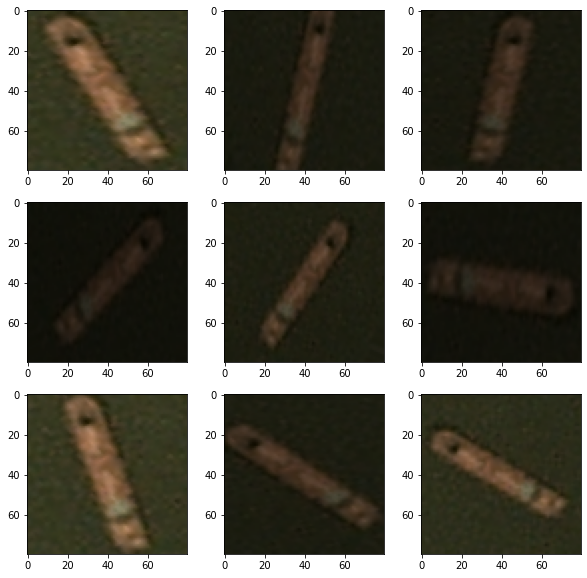

In [43]:
data = x_reshaped[y==1][15]
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datag = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          horizontal_flip=True,
                          rotation_range=90)
# prepare iterator
it = datag.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize = (10,10))
for i in range(9):
    # define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    # show the figure
plt.show()

<p>
<font size="4" face="Arial">
<li> Now I will apply data augmentation to train data and fit again.  </li>
</font>
</p>

In [44]:
history = model.fit(datagen.flow(x_train, y_train), epochs = 100, 
                    validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 15s 198ms/step - loss: 0.2369 - accuracy: 0.9333 - val_loss: 0.0762 - val_accuracy: 0.9812
Epoch 2/100
75/75 [==============================] - 14s 190ms/step - loss: 0.1319 - accuracy: 0.9492 - val_loss: 0.0841 - val_accuracy: 0.9787
Epoch 3/100
75/75 [==============================] - 16s 208ms/step - loss: 0.1323 - accuracy: 0.9563 - val_loss: 0.0698 - val_accuracy: 0.9800
Epoch 4/100
75/75 [==============================] - 14s 190ms/step - loss: 0.1214 - accuracy: 0.9588 - val_loss: 0.0679 - val_accuracy: 0.9812
Epoch 5/100
75/75 [==============================] - 15s 204ms/step - loss: 0.1241 - accuracy: 0.9546 - val_loss: 0.0793 - val_accuracy: 0.9750
Epoch 6/100
75/75 [==============================] - 14s 188ms/step - loss: 0.1191 - accuracy: 0.9625 - val_loss: 0.0719 - val_accuracy: 0.9700
Epoch 7/100
75/75 [==============================] - 15s 203ms/step - loss: 0.1110 - accuracy: 0.9692 - val_loss: 0.0663 - val_accuracy:

In [45]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 1s 42ms/step - loss: 0.0380 - accuracy: 0.9887


[0.038018848747015, 0.9887499809265137]


Test Accuracy Score :  0.98875 



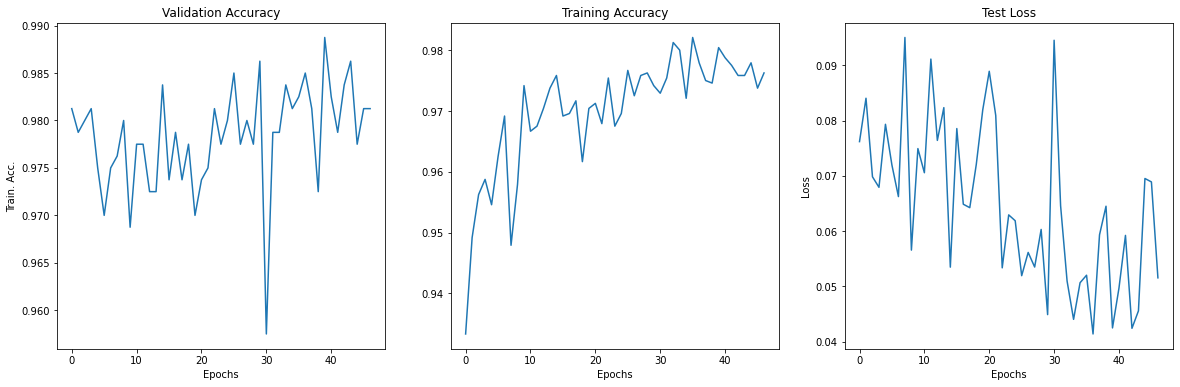

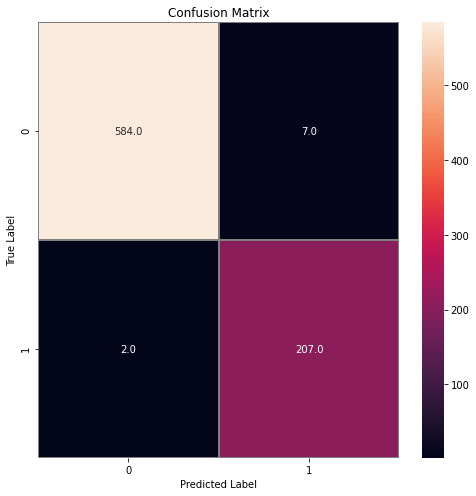

In [46]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

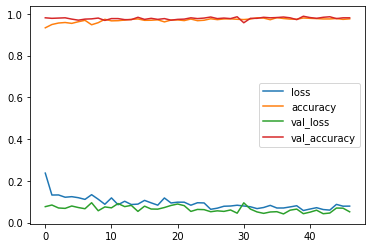

In [47]:
pd.DataFrame(history.history).plot();

<p>
<font size="4" face="Arial">
<li> Now we can predict our test data with CNN. I check the first image of the test data.  </li>
</font>
</p>

In [48]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

Not A Ship    0.002873
Ship          0.997127
dtype: float32

<p>
<font size="4" face="Arial">
<li> You can see that we get a result with a much higher probability than the model we created with ANN. </li>
<li> Let's take a look at the images that are estimated to be ship, although not a ship. </li>
</font>
</p>

In [49]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head(3)

,Not A Ship,Ship
0,0.002873,9.971266e-01
1,1.000000,8.802750e-11
2,0.000240,9.997604e-01


In [50]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(3)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0


In [51]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.002873,9.971266e-01,1.0
1,1.000000,8.802750e-11,0.0
2,0.000240,9.997604e-01,1.0
3,0.969701,3.029878e-02,0.0
4,1.000000,1.710891e-15,0.0


In [52]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.002873,9.971266e-01,1.0,-2.873361e-03
1,1.000000,8.802750e-11,0.0,8.802750e-11
2,0.000240,9.997604e-01,1.0,-2.395511e-04
3,0.969701,3.029878e-02,0.0,3.029878e-02
4,1.000000,1.710891e-15,0.0,1.710891e-15
...,...,...,...,...
795,0.232863,7.671368e-01,0.0,7.671368e-01
796,0.038530,9.614696e-01,1.0,-3.853041e-02
797,0.999974,2.582775e-05,0.0,2.582775e-05
798,1.000000,3.312061e-15,0.0,3.312061e-15


<p>
<font size="4" face="Arial">
<li> If difference is high, that means the image predicted as Ship, altought not a ship. To see such predicted images, we need to sort the difference column from largest to smallest. </li>
</font>
</p>

In [53]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
461,0.063055,0.936945,0.0,0.936945
747,0.182278,0.817722,0.0,0.817722
717,0.215398,0.784602,0.0,0.784602
628,0.223205,0.776795,0.0,0.776795
795,0.232863,0.767137,0.0,0.767137
379,0.248669,0.751331,0.0,0.751331
564,0.261130,0.738871,0.0,0.738871
246,0.519092,0.480908,0.0,0.480908
413,0.559747,0.440253,0.0,0.440253
492,0.595908,0.404092,0.0,0.404092


<p>
<font size="4" face="Arial">
<li> Now, I want to show some of these images and their pixel intensity histograms. </li>
</font>
</p>

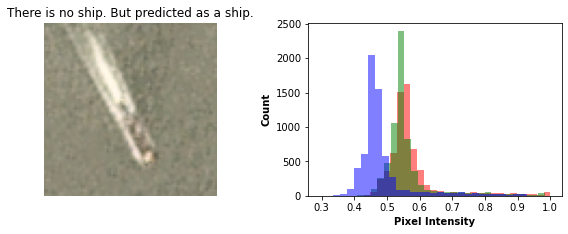

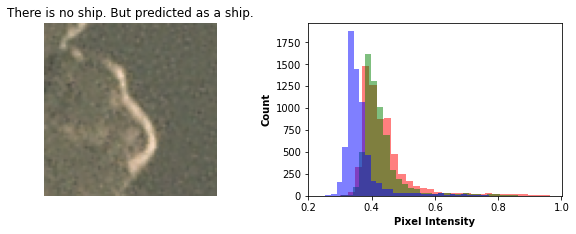

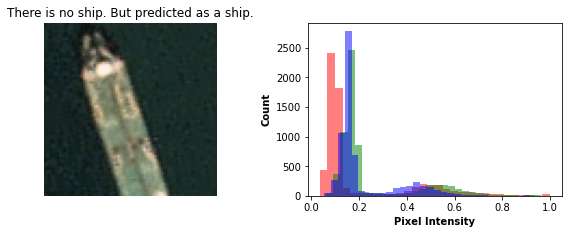

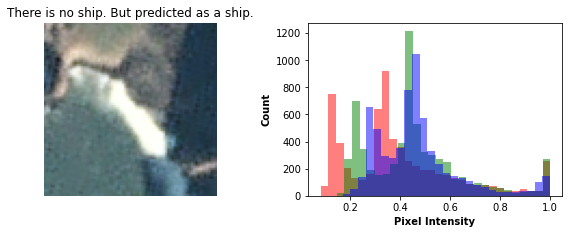

In [54]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


#Implementation of the function

for i in indexes:
    plotHistogram(i)

<p>
<font size="4" face="Arial">
<li> In conclusion, we achieve the best test accuracy with Convolutional Neurol Network.</li>
</font>
</p>

<font size="5" face="Arial">



<p>
<font size="4" face="Arial">Please uptove and make comment if you like my notebook.
</font>
</p>
<p>
<font size="4" face="Arial">Thanks!</font>
</p>